<a href="https://colab.research.google.com/github/42bismuth/Alzheimer-Detection/blob/main/nlp/Alzheimer's_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.metrics import accuracy_score, log_loss
import sklearn
import string
import seaborn as sns
from keras.optimizers import Adam
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

## Reading and analysing data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
path = r"/content/drive/MyDrive/alzhiemers.csv"
df = pd.read_csv(path, sep="\t", encoding = 'latin1')

In [5]:
df

,"AD,Transcripts"
0,"0, the scene is in the in the kitchen . the mo..."
1,"0,"" oh I see the sink is running over . I see ..."
2,"0, a boy and a girl are in the kitchen with th..."
3,"0, it was summertime and mother and the child..."
4,"0, wait until I put my glasses on . oh ? there..."
...,...
493,"1, well this one is in the cookie jar . and t..."
494,"1, the little boy is on the stool which is ti..."
495,"1, oh you want me to tell you . the mother and..."
496,"1, oh that kid's gonna get a good spill off of..."


In [6]:
df.iloc[271]

AD,Transcripts    1, oh I see . well the kitchen sink is that th...
Name: 271, dtype: object

In [ ]:
len(df)

498

In [24]:
df[['AD', 'Transcripts']] = df['AD,Transcripts'].str.split("," , n =1, expand=True)

df['Transcripts'] = df['Transcripts'].str.strip()

In [25]:
del df['AD,Transcripts']

In [26]:
def create_sentence_pairs(row):
    sentences = row['Transcripts'].split('.')
    pairs = [sentences[i] + sentences[i+1] for i in range(0, len(sentences)-1, 2)]
    labels = [row['AD']] * len(pairs)
    return pd.DataFrame({'Transcripts': pairs, 'AD': labels})

# Apply the function to each row
new_df = pd.concat(df.apply(create_sentence_pairs, axis=1).tolist(), ignore_index=True)

print(new_df)

                                            Transcripts AD
0     the scene is in the in the kitchen  the mother...  0
1      a child is trying to get a boy is trying to g...  0
2        it seems to be summer out  the window is open   0
3      the curtains are blowing  it must be a gentle...  0
4      there's grass outside in the garden  mother's...  0
...                                                 ... ..
2820   the little girl's reaching up there to get so...  1
2821  ah oh boy   oh the kids are trying to get the ...  1
2822   and she's laughing but holding her hand up to...  1
2823   and their mother's doing the dishes and not d...  1
2824   that's all I can and tup two cups and a plate...  1

[2825 rows x 2 columns]


In [ ]:
split_transcripts = df['Transcripts'].str.split('.')
print(split_transcripts)

repeated_labels = [label for label, sentences_list in zip(df['AD'], split_transcripts) for _ in sentences_list]
print(len(repeated_labels))

sentences = [sentence.strip() for sentences_list in split_transcripts for sentence in sentences_list]
print(len(sentences))

if len(repeated_labels) != len(sentences):
    raise ValueError("Lengths of arrays must match")


new_df = pd.DataFrame({
    'Transcripts': sentences,
    'AD': repeated_labels
})


new_df.reset_index(drop=True, inplace=True)

0      [the scene is in the in the kitchen ,  the mot...
1      [" oh I see the sink is running over ,  I see ...
2      [a boy and a girl are in the kitchen with thei...
3      [it was summertime and mother and the children...
4      [wait until I put my glasses on ,  oh ? there'...
                             ...                        
493    [well this one is in the cookie jar ,  and thi...
494    [the little boy is on the stool which is tippi...
495    [oh you want me to tell you ,  the mother and ...
496    [oh that kid's gonna get a good spill off of t...
497    [ah oh boy ,   oh the kids are trying to get t...
Name: Transcripts, Length: 498, dtype: object
5902
5902


In [27]:
new_df['AD'] = new_df['AD'].astype('int')

In [ ]:
word_counts = new_df['Transcripts'].str.split().str.len()

new_df = new_df[word_counts > 4]

new_df.reset_index(drop=True, inplace=True)

In [28]:
new_df

,Transcripts,AD
0,the scene is in the in the kitchen the mother...,0
1,a child is trying to get a boy is trying to g...,0
2,it seems to be summer out the window is open,0
3,the curtains are blowing it must be a gentle...,0
4,there's grass outside in the garden mother's...,0
...,...,...
2820,the little girl's reaching up there to get so...,1
2821,ah oh boy oh the kids are trying to get the ...,1
2822,and she's laughing but holding her hand up to...,1
2823,and their mother's doing the dishes and not d...,1


In [29]:
df = new_df

Class 0 samples:  1421
Class 1 samples:  1404


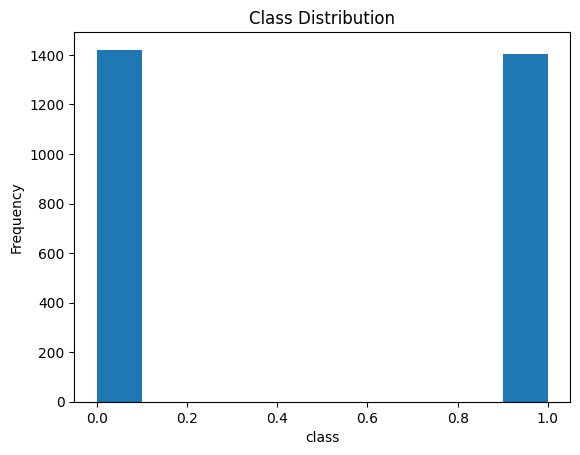

In [30]:
counts, bins = np.histogram(df['AD'])
plt.hist(bins[:-1], bins, weights=counts)
plt.title("Class Distribution")
plt.xlabel('class')
plt.ylabel('Frequency')
print("Class 0 samples: ",len(df[df['AD']==0]))
print("Class 1 samples: ",len(df[df['AD']==1]))
plt.show()

## Preprocess data
1. Clean data
2. remove stop words
3. Apply Stemming (optional)
3. Apply lemmatization (Optional)

In [17]:
# clean data. Keep only english alphabets

In [31]:
import string

table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
string_punctuation_1 = string.punctuation.replace(".","").replace("`","").replace("'","")
table_ = str.maketrans(string_punctuation_1, ' '*len(string_punctuation_1))
printable = set(string.printable)


def clean_data(text):


    sentence = text.lower()
    sentence_no_punct = sentence.translate(table_)
    space_remove = re.sub('\s+',' ', sentence_no_punct)
    return space_remove


In [32]:
df['Transcripts_cleaned'] = df['Transcripts'].apply(lambda row: clean_data(row) )

In [33]:
df['Transcripts_cleaned'].iloc[2051] , df['AD'].iloc[2051]

(" we got a faucet turned on and water's overflowing from the sink onto the floor grass is growing on the outside trees are growing ",
 0)

In [34]:
#stemming data (optional)

In [35]:
stemmer = SnowballStemmer('english')
def stem_words(text):
    text = text.split()
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

In [36]:
df['Transcripts_stem'] = df['Transcripts_cleaned'].apply(lambda row: stem_words(row))

In [37]:
df['Transcripts_stem']

0       the scene is in the in the kitchen the mother ...
1       a child is tri to get a boy is tri to get cook...
2             it seem to be summer out the window is open
3           the curtain are blow it must be a gentl breez
4       there grass outsid in the garden mother finish...
                              ...                        
2820    the littl girl reach up there to get someth fr...
2821        ah oh boy oh the kid are tri to get the cooki
2822    and she laugh but hold her hand up to him and ...
2823    and their mother do the dish and not do not be...
2824       that all i can and tup two cup and a plate end
Name: Transcripts_stem, Length: 2825, dtype: object

In [ ]:
#Lemmatizing data (optional)

In [38]:
lemmatizer = WordNetLemmatizer()

In [39]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [40]:
df['Transcripts_lem'] = df['Transcripts_cleaned'].apply(lambda row: " ".join([lemmatizer.lemmatize(i) for i in word_tokenize(row)]))

In [41]:
df['Transcripts_lem']

0       the scene is in the in the kitchen the mother ...
1       a child is trying to get a boy is trying to ge...
2            it seems to be summer out the window is open
3       the curtain are blowing it must be a gentle br...
4       there 's grass outside in the garden mother 's...
                              ...                        
2820    the little girl 's reaching up there to get so...
2821     ah oh boy oh the kid are trying to get the cooky
2822    and she 's laughing but holding her hand up to...
2823    and their mother 's doing the dish and not doi...
2824    that 's all i can and tup two cup and a plate end
Name: Transcripts_lem, Length: 2825, dtype: object

## TF-IDF approach

In [42]:
#transforming sentences to vectors
vectorizer = TfidfVectorizer(stop_words='english',max_features=1000,min_df=5, max_df=0.9)
X = vectorizer.fit_transform(df['Transcripts_lem'].tolist())

In [43]:
X.shape

(2825, 355)

In [44]:
#checking the weights assigned to each word
# Checking the weights assigned to each word

sorted([x for x in zip(vectorizer.get_feature_names_out(), vectorizer.idf_)], key=lambda x:x[1], reverse=True)

[('alright', 7.154858094016418),
 ('beginning', 7.154858094016418),
 ('better', 7.154858094016418),
 ('bowl', 7.154858094016418),
 ('broke', 7.154858094016418),
 ('cake', 7.154858094016418),
 ('closet', 7.154858094016418),
 ('clothes', 7.154858094016418),
 ('dangerous', 7.154858094016418),
 ('dirty', 7.154858094016418),
 ('dishwasher', 7.154858094016418),
 ('dressed', 7.154858094016418),
 ('drop', 7.154858094016418),
 ('dropped', 7.154858094016418),
 ('family', 7.154858094016418),
 ('finished', 7.154858094016418),
 ('food', 7.154858094016418),
 ('glass', 7.154858094016418),
 ('grab', 7.154858094016418),
 ('happy', 7.154858094016418),
 ('hard', 7.154858094016418),
 ('having', 7.154858094016418),
 ('help', 7.154858094016418),
 ('hmhunh', 7.154858094016418),
 ('laying', 7.154858094016418),
 ('meant', 7.154858094016418),
 ('mind', 7.154858094016418),
 ('mop', 7.154858094016418),
 ('near', 7.154858094016418),
 ('outta', 7.154858094016418),
 ('poor', 7.154858094016418),
 ('presume', 7.154858

In [45]:
X = X.toarray()
y= np.array(df['AD'].tolist())

In [50]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42  )

In [47]:
models_f1 = []
models_f1.append((LogisticRegression()))
# models_f1.append((GridSearchCV(), LinearDiscriminantAnalysis()))
models_f1.append(( KNeighborsClassifier()))
models_f1.append((DecisionTreeClassifier()))
models_f1.append((MultinomialNB()))
models_f1.append((SVC(kernel="linear", C=0.1,probability=True)))
models_f1.append((RandomForestClassifier()))
models_f1.append((AdaBoostClassifier()))

In [48]:
import pandas as pd
!pip install --upgrade pandas
print(pd.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 48.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.
2.0.3


LogisticRegression
****Results****
Accuracy: 67.9646%
****F1 score,Precision and recall****
f1_score: 0.6795456325891109 , Precison: 0.6795426065162907, Recall: 0.6796551724137931, Individual_f1: [0.68521739 0.67387387]
(array([0.69122807, 0.66785714]), array([0.67931034, 0.68      ]), array([0.68521739, 0.67387387]), array([290, 275]))
***confusion matrix****


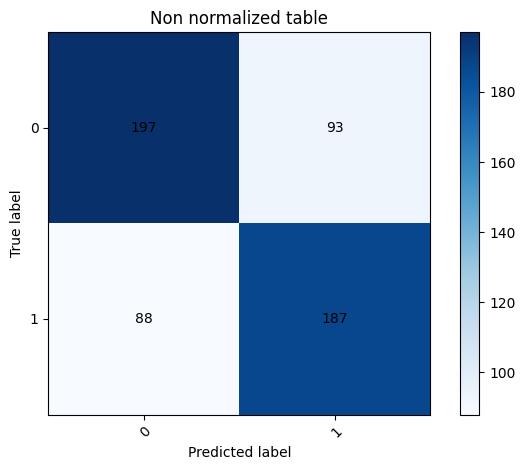

Log Loss: 0.5958597389482518
KNeighborsClassifier
****Results****
Accuracy: 61.9469%
****F1 score,Precision and recall****
f1_score: 0.6002126056034411 , Precison: 0.6373539269861401, Recall: 0.6140752351097178, Individual_f1: [0.68795356 0.51247166]
(array([0.59398496, 0.68072289]), array([0.81724138, 0.41090909]), array([0.68795356, 0.51247166]), array([290, 275]))
***confusion matrix****


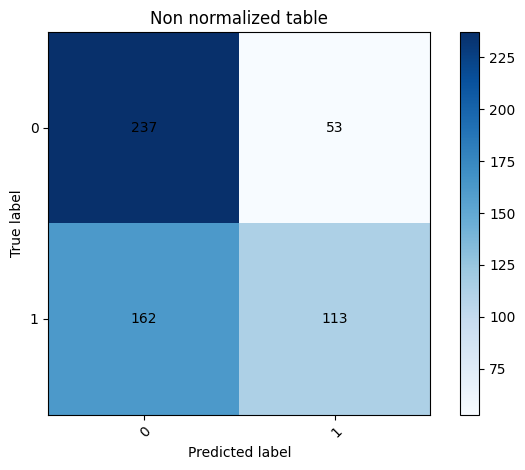

Log Loss: 2.31888709790707
DecisionTreeClassifier
****Results****
Accuracy: 63.3628%
****F1 score,Precision and recall****
f1_score: 0.6324493009135735 , Precison: 0.6334810494154484, Recall: 0.6325705329153606, Individual_f1: [0.65326633 0.61163227]
(array([0.63517915, 0.63178295]), array([0.67241379, 0.59272727]), array([0.65326633, 0.61163227]), array([290, 275]))
***confusion matrix****


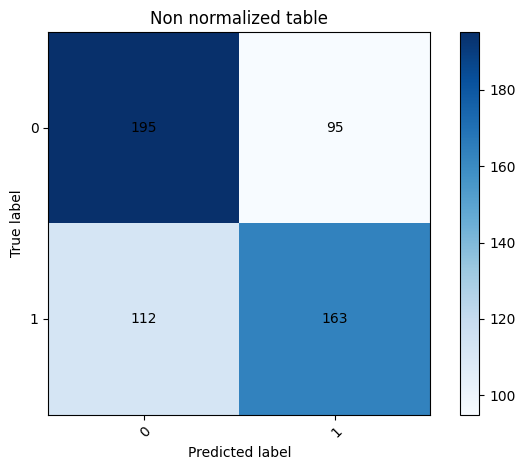

Log Loss: 12.354937521728925
MultinomialNB
****Results****
Accuracy: 67.9646%
****F1 score,Precision and recall****
f1_score: 0.6780322707595435 , Precison: 0.6805079365079365, Recall: 0.6782445141065832, Individual_f1: [0.70082645 0.6552381 ]
(array([0.67301587, 0.688     ]), array([0.73103448, 0.62545455]), array([0.70082645, 0.6552381 ]), array([290, 275]))
***confusion matrix****


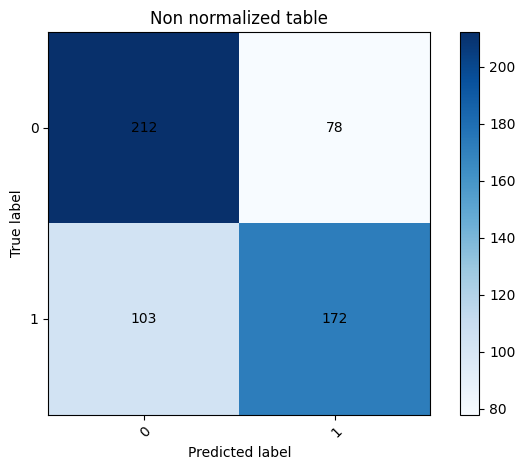

Log Loss: 0.6111165775023583
SVC
****Results****
Accuracy: 67.7876%
****F1 score,Precision and recall****
f1_score: 0.6778670242093128 , Precison: 0.6781327551199459, Recall: 0.6782131661442006, Individual_f1: [0.67957746 0.67615658]
(array([0.6942446 , 0.66202091]), array([0.66551724, 0.69090909]), array([0.67957746, 0.67615658]), array([290, 275]))
***confusion matrix****


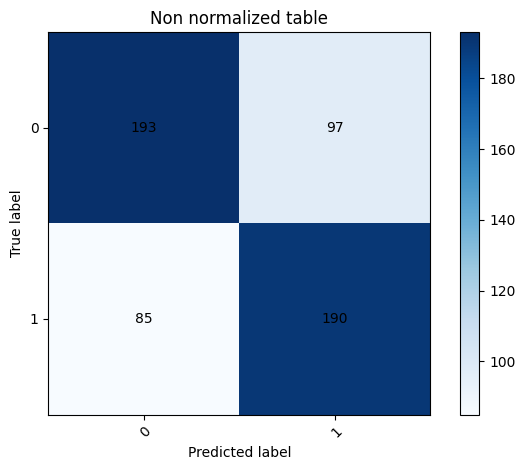

Log Loss: 0.6028061461481756
RandomForestClassifier
****Results****
Accuracy: 69.3805%
****F1 score,Precision and recall****
f1_score: 0.6919370038041028 , Precison: 0.6953513265540179, Recall: 0.6922257053291536, Individual_f1: [0.71592775 0.66794626]
(array([0.68338558, 0.70731707]), array([0.75172414, 0.63272727]), array([0.71592775, 0.66794626]), array([290, 275]))
***confusion matrix****


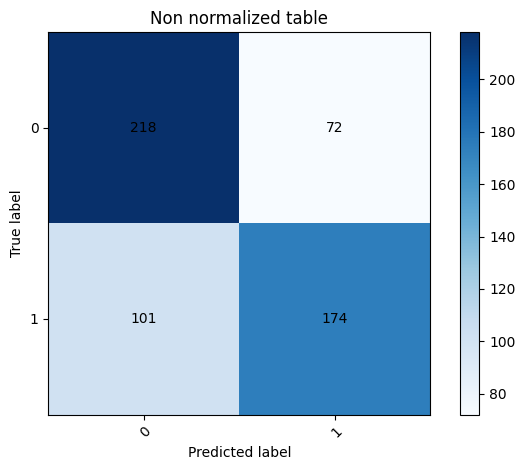

Log Loss: 0.5828436543952835
AdaBoostClassifier
****Results****
Accuracy: 65.6637%
****F1 score,Precision and recall****
f1_score: 0.6566360925243716 , Precison: 0.6570257258913796, Recall: 0.6570532915360501, Individual_f1: [0.65724382 0.65602837]
(array([0.67391304, 0.64013841]), array([0.64137931, 0.67272727]), array([0.65724382, 0.65602837]), array([290, 275]))
***confusion matrix****


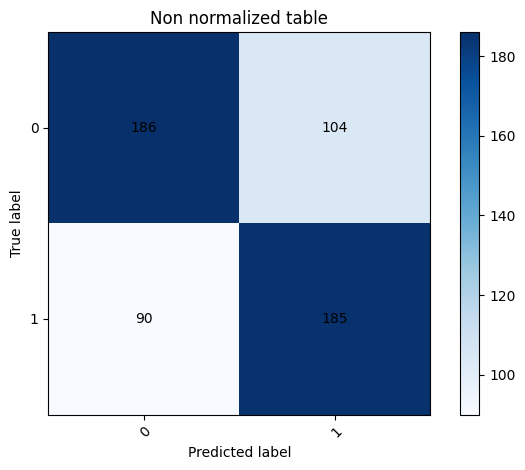

Log Loss: 0.6845733153755623


In [51]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)
for clf in models_f1:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__

    print("="*30)
    print(name)

    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))

    print('****F1 score,Precision and recall****')
    f1_score = sklearn.metrics.f1_score(y_test, train_predictions,average='macro')
    Precision = sklearn.metrics.precision_score(y_test, train_predictions,average='macro')
    Recall = sklearn.metrics.recall_score(y_test, train_predictions,average='macro')
    individual_f1 = sklearn.metrics.f1_score(y_test, train_predictions, average=None)
    print("f1_score: {} , Precison: {}, Recall: {}, Individual_f1: {}".format(f1_score,Precision,Recall,individual_f1))
    print(precision_recall_fscore_support(y_test, train_predictions, average=None, labels=df['AD'].unique()))
    print('***confusion matrix****')
    classes = df['AD'].unique()
    cm = confusion_matrix(y_test, train_predictions)
    fig, ax = plt.subplots()
    cmap=plt.cm.Blues
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title="Non normalized table",
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    normalize = False
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 3.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="black")
    fig.tight_layout()
    plt.show()

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))

    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = pd.concat([log, log_entry])

### Grid Search + SVM

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, classification_report
import joblib
svc = SVC(probability=True)
parameters = {'kernel':('linear','rbf'), 'C':[0.01, 10]}
model = GridSearchCV(svc,parameters)
model.fit(X_train, y_train)
print(model)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

labels = [0, 1]
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average=None, labels= labels))


GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.01, 10], 'kernel': ('linear', 'rbf')})
0.6902654867256637
[[207  83]
 [ 92 183]]
(array([0.69230769, 0.68796992]), array([0.7137931 , 0.66545455]), array([0.70288625, 0.67652495]), array([290, 275]))


In [53]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70       290
           1       0.69      0.67      0.68       275

    accuracy                           0.69       565
   macro avg       0.69      0.69      0.69       565
weighted avg       0.69      0.69      0.69       565



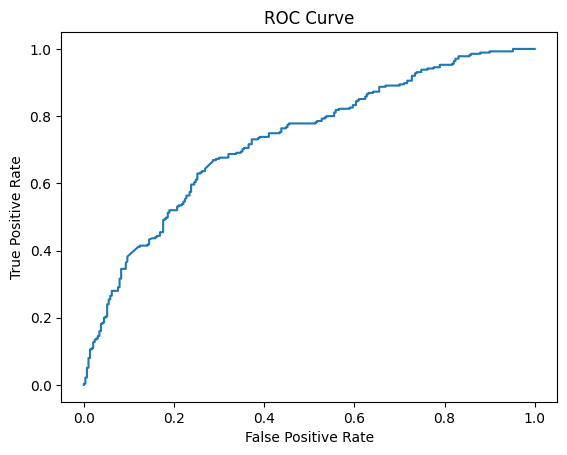

In [54]:
from sklearn.metrics import roc_curve , roc_auc_score
y_probas = model.predict_proba(X_test)[:,1]
#skplt.metrics.plot_roc_curve(y_test, y_probas)
fpr, tpr, thresholds = roc_curve(y_test, y_probas)
#roc_auc = roc_auc_score(y_test, scores)
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()

Random Forest

In [55]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
print(model_rf)
y_pred = model_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

labels = [0, 1]
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average=None, labels= labels))
print(classification_report(y_test,y_pred))

RandomForestClassifier()
0.6938053097345133
[[211  79]
 [ 94 181]]
(array([0.69180328, 0.69615385]), array([0.72758621, 0.65818182]), array([0.7092437 , 0.67663551]), array([290, 275]))
              precision    recall  f1-score   support

           0       0.69      0.73      0.71       290
           1       0.70      0.66      0.68       275

    accuracy                           0.69       565
   macro avg       0.69      0.69      0.69       565
weighted avg       0.69      0.69      0.69       565



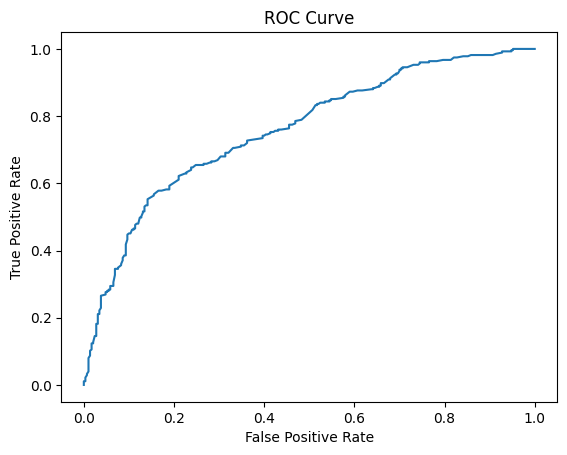

In [56]:
from sklearn.metrics import roc_curve , roc_auc_score
y_probas = model_rf.predict_proba(X_test)[:,1]
#skplt.metrics.plot_roc_curve(y_test, y_probas)
fpr, tpr, thresholds = roc_curve(y_test, y_probas)
#roc_auc = roc_auc_score(y_test, scores)
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()

Decision Tree

In [59]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
print(model_dt)
y_pred = model_dt.predict(X_test)
acc = accuracy_score(y_test, y_pred)

labels = [0, 1]
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average=None, labels= labels))
print(classification_report(y_test,y_pred))

DecisionTreeClassifier()
0.6336283185840708
[[197  93]
 [114 161]]
(array([0.63344051, 0.63385827]), array([0.67931034, 0.58545455]), array([0.65557404, 0.60869565]), array([290, 275]))
              precision    recall  f1-score   support

           0       0.63      0.68      0.66       290
           1       0.63      0.59      0.61       275

    accuracy                           0.63       565
   macro avg       0.63      0.63      0.63       565
weighted avg       0.63      0.63      0.63       565



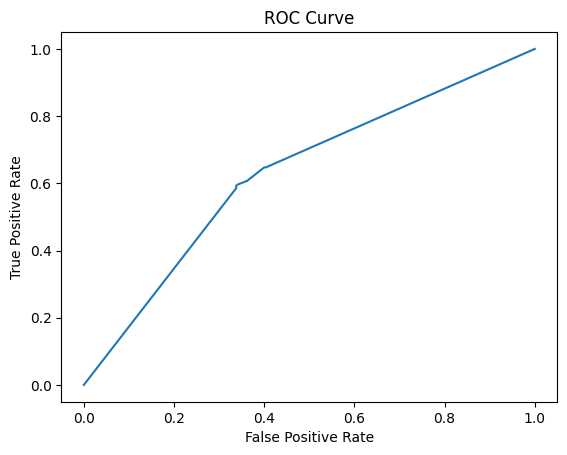

In [58]:
from sklearn.metrics import roc_curve , roc_auc_score
y_probas = model_dt.predict_proba(X_test)[:,1]
#skplt.metrics.plot_roc_curve(y_test, y_probas)
fpr, tpr, thresholds = roc_curve(y_test, y_probas)
#roc_auc = roc_auc_score(y_test, scores)
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()

Deep learning

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Dropout,Conv1D, Flatten, MaxPooling1D, Dense, LSTM,Conv1D,MaxPooling1D, Bidirectional
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import History

%matplotlib inline

In [ ]:
X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(df['Transcripts_cleaned'], df['AD'], test_size = 0.1, random_state = 0)

In [ ]:

tokenizer = Tokenizer(num_words = 2500)
tokenizer.fit_on_texts(X_seq_train)

Xwords_train = tokenizer.texts_to_sequences(X_seq_train)
Xwords_test = tokenizer.texts_to_sequences(X_seq_test)

In [ ]:
max_review_length = 100
Xwords_train = sequence.pad_sequences(Xwords_train, maxlen=max_review_length)
Xwords_test = sequence.pad_sequences(Xwords_test, maxlen=max_review_length)

In [ ]:
print(Xwords_train.shape)
print(Xwords_test.shape)
print(y_seq_train.shape)
print(y_seq_test.shape)

(3930, 100)
(437, 100)
(3930,)
(437,)


In [ ]:
vocab = len(tokenizer.word_index) + 1   # Add one for the zero indexing
vocab

1591

In [ ]:
#setting history parameter to record accuracy and loss info of model

history = History()

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = vocab, output_dim = 100, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(Xwords_train, y_seq_train, epochs=50, batch_size=256,verbose = 1,callbacks = [history],validation_split=0.1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          159100    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 276477 (1.05 MB)
Trainable params: 276477 (1.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
14/14 [==============================] - 32s 2s/step - loss: 0.6908 - accuracy: 0.5256 - val_loss: 0.6869 - val_accuracy: 0.5293
Epoch 2/50
14/14 [==============================] - 19s 1s/step - loss: 0.6655 - accuracy: 0.6373 - val_loss: 0.6400 - val_accuracy: 0.6514

In [ ]:
eval_list = model.evaluate(Xwords_test,y_seq_test)
print('Test Loss: ',eval_list[0])
print('Test Accuracy: ',eval_list[1])

14/14 [==============================] - 2s 137ms/step - loss: 1.0789 - accuracy: 0.6728
Test Loss:  1.078880786895752
Test Accuracy:  0.6727688908576965


14/14 [==============================] - 2s 103ms/step


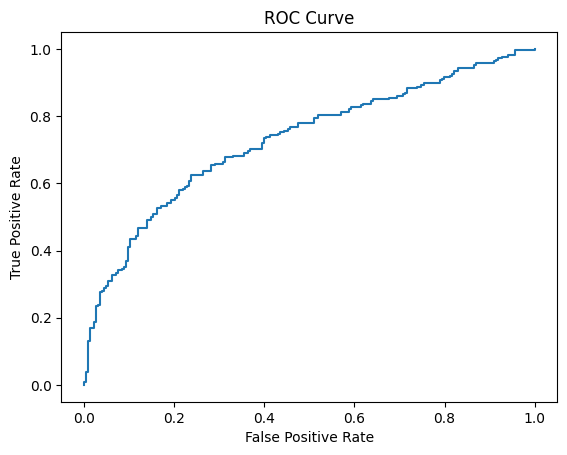

In [ ]:
y_pred_probas = model.predict(Xwords_test)
y_pred_probas = [i[0] for i in y_pred_probas]
fpr, tpr, thresholds = roc_curve(y_seq_test, y_pred_probas)
#roc_auc = roc_auc_score(y_test, scores)
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()

In [ ]:
# Predicting classes on test data
y_pred_prob = model.predict(Xwords_test)
y_pred = y_pred_prob.argmax(axis=1)


14/14 [==============================] - 2s 105ms/step


In [ ]:
print(confusion_matrix(y_seq_test, y_pred))
print(classification_report(y_seq_test,y_pred))

[[223   0]
 [214   0]]
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       223
           1       0.00      0.00      0.00       214

    accuracy                           0.51       437
   macro avg       0.26      0.50      0.34       437
weighted avg       0.26      0.51      0.34       437



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


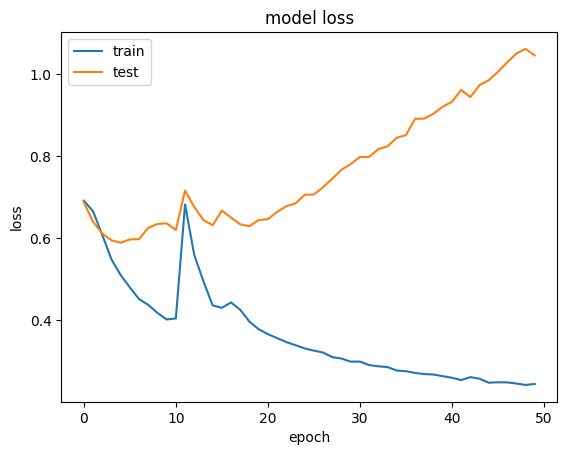

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

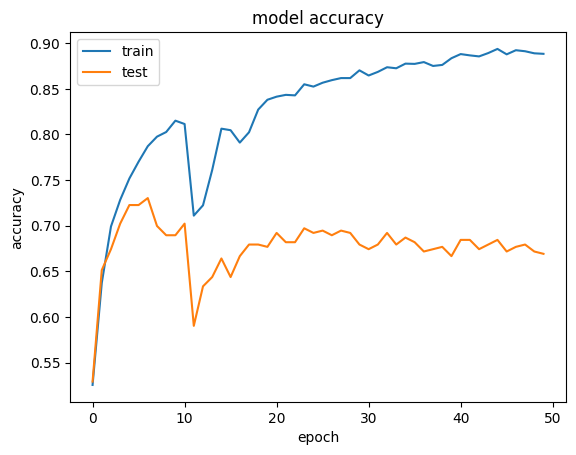

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Bidirectional LSTM

In [ ]:
model_bilstm = Sequential()
model_bilstm.add(Embedding(input_dim = vocab, output_dim = 100, input_length=100))
model_bilstm.add(Bidirectional(LSTM(128, recurrent_dropout=0.2)))
model_bilstm.add(Dense(1, activation='sigmoid'))
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_bilstm.summary())

model_bilstm.fit(Xwords_train, y_seq_train, epochs=50, batch_size=256,verbose = 1,callbacks = [history],validation_split=0.1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          159100    
                                                                 
 bidirectional (Bidirection  (None, 256)               234496    
 al)                                                             
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 393853 (1.50 MB)
Trainable params: 393853 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
14/14 [==============================] - 55s 3s/step - loss: 0.6908 - accuracy: 0.5338 - val_loss: 0.6859 - val_accuracy: 0.6005
Epoch 2/50
14/14 [==============================] - 32s 2s/step - loss:

In [ ]:
eval_list = model_bilstm.evaluate(Xwords_test,y_seq_test)
print('Test Loss: ',eval_list[0])
print('Test Accuracy: ',eval_list[1])

14/14 [==============================] - 2s 145ms/step - loss: 1.2506 - accuracy: 0.6705
Test Loss:  1.250593900680542
Test Accuracy:  0.6704805493354797


In [ ]:
model_bilstm.save('saved_models/model_bilstm.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 75ms/step


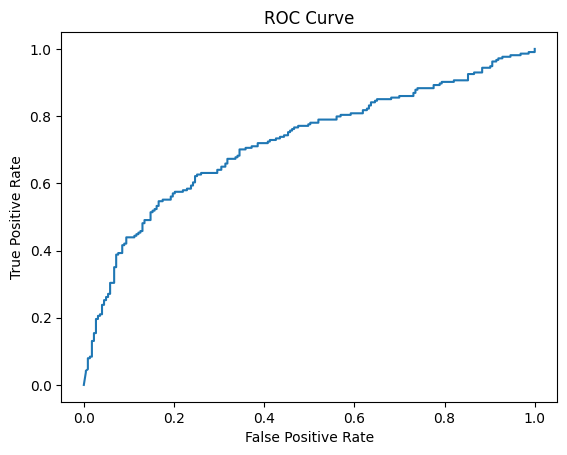

In [ ]:
y_pred_probas = model_bilstm.predict(Xwords_test)
y_pred_probas = [i[0] for i in y_pred_probas]
fpr, tpr, thresholds = roc_curve(y_seq_test, y_pred_probas)
#roc_auc = roc_auc_score(y_test, scores)
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()

In [ ]:
# Predict probabilities on test data
y_pred_prob = model_bilstm.predict(Xwords_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

14/14 [==============================] - 1s 80ms/step


In [ ]:
print(confusion_matrix(y_seq_test, y_pred))
print(classification_report(y_seq_test,y_pred))

[[223   0]
 [214   0]]
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       223
           1       0.00      0.00      0.00       214

    accuracy                           0.51       437
   macro avg       0.26      0.50      0.34       437
weighted avg       0.26      0.51      0.34       437



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


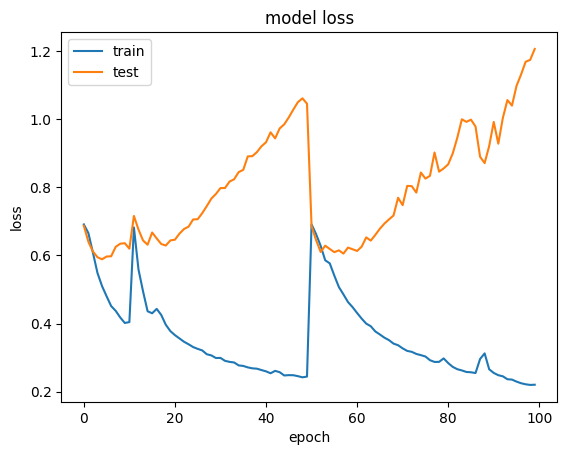

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

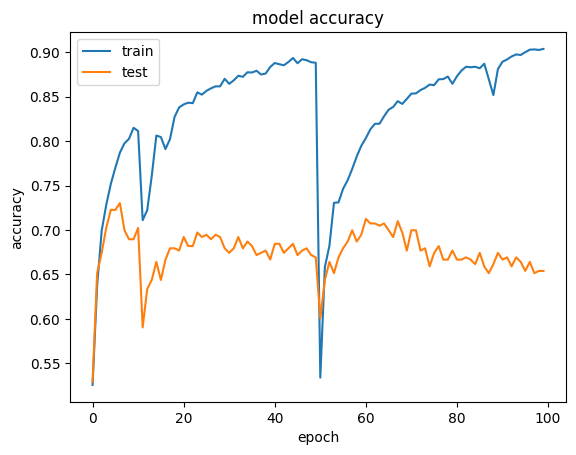

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()